In [2]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import segyio # não sendo usada
import scipy.signal
import scipy.interpolate
import pylops
import seaborn as sns
import scipy.linalg
from numpy.linalg import inv
import warnings
warnings.filterwarnings("ignore")

sns.set_theme()

In [4]:
# Function that stores the slicing

def slicing(data, index, axis):
    if axis == 'x':
        return data[index, :, :]
    elif axis == 'y':
        return data[:, index, :]
    elif axis == 'z':
        return data[:, :, index]
    else:
        print("Axis must be 0, 1 or 2")
        return None

In [5]:
# The data below is on the usb stick
data_amp = np.load("J:\\Universidade\\IC\\Amplitude\\model0.npy")
data_faults = np.load("J:\\Universidade\\IC\\Faults\\model0.npy")
data_imp = np.load("J:\\Universidade\\IC\\Impedance\\model0.npy")
####################################################################
# data_amp = np.load("F:\\Universidade\\IC\\Amplitude\\model0.npy")
# data_faults = np.load("F:\\Universidade\\IC\\Faults\\model0.npy")
# data_imp = np.load("F:\\Universidade\\IC\\Impedance\\model0.npy")

print(f" data shape {np.shape(data_amp)}")
print(f" data shape {np.shape(data_faults)}")
print(f" data shape {np.shape(data_imp)}")

 data shape (256, 256, 256)
 data shape (256, 256, 256)
 data shape (256, 256, 256)


In [6]:
np.shape(data_imp[:,:,1])

(256, 256)

Gerando a wavelet de Ricker

In [7]:
def ricker(f, length=0.128, dt=0.001):
    t = np.arange(-length/2, (length-dt)/2, dt)
    wlet = (1.0 - 2.0*(np.pi**2)*(f**2)*(t**2)) * np.exp(-(np.pi**2)*(f**2)*(t**2))

    return t, wlet

twlet, wlet = ricker(f=30, length=0.256, dt=0.004)          # wavelet

Se está pegando o nz, nx e ny. Fazendo um desenho:

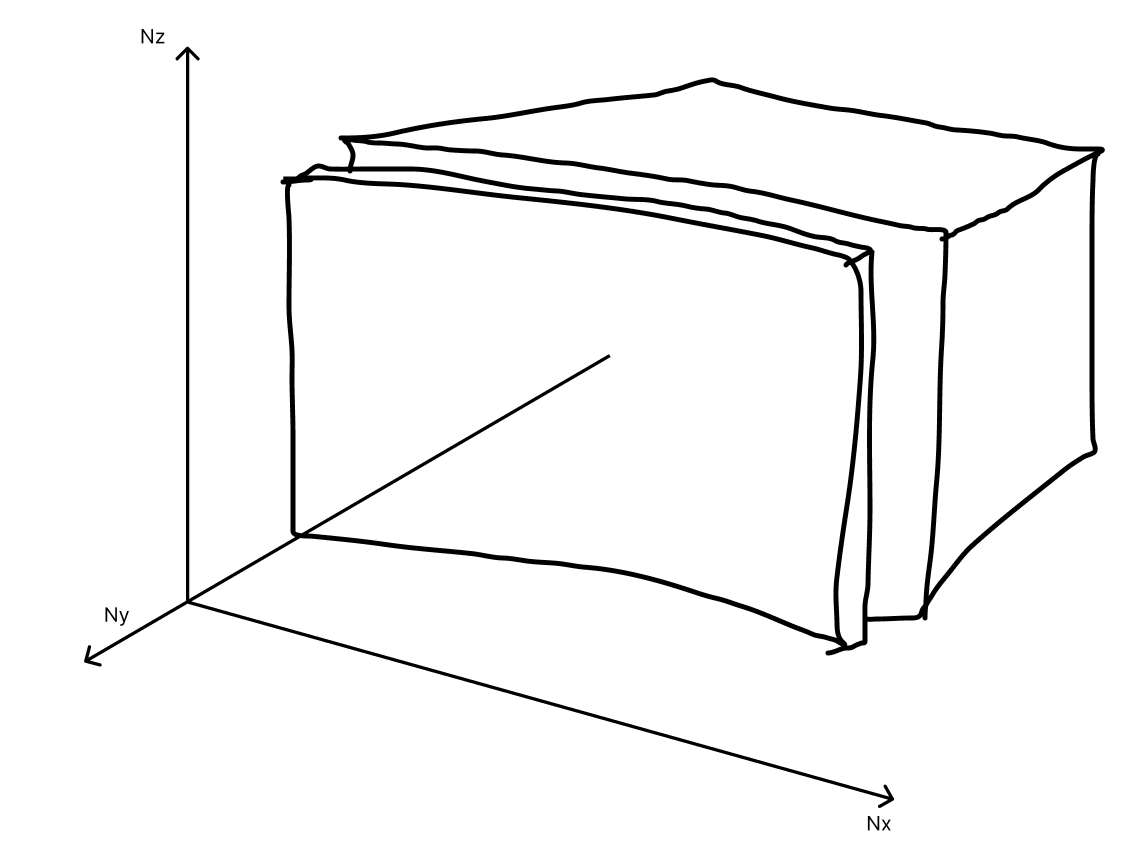

Então, cada operador PPop precisa ser aplicado em cada seção nz e nx, até o número de ny.

In [48]:
# Parâmetros do operador
nz, nx, ny = data_amp.shape

# Wavelet operator (assumindo que wlet é sua wavelet)
PPop = pylops.avo.poststack.PoststackLinearModelling(wlet/2,
                                                     nt0=nz,
                                                     spatdims=nx,
                                                     explicit=True)

In [67]:
# Parâmetros do operador
nz, nx, ny = data_amp.shape

# Wavelet operator (assumindo que wlet é sua wavelet)
PPop = pylops.avo.poststack.PoststackLinearModelling(wlet/2,
                                                     nt0=nz,
                                                     spatdims=nx,
                                                     explicit=True)
# Placeholder para os resultados da impedância acústica invertida
inverted_impedance = np.zeros_like(data_imp)

# Loop ao longo do eixo y para aplicar a inversão em cada seção de x-z
for iy in range(ny):
    # Selecionar a seção sísmica e a impedância para a posição atual y
    seismic_section = data_amp[:, :, iy]
    impedance_section = data_imp[:, :, iy]

    # Aplicar a inversão usando o operador PPop e os dados de amplitude
    # A inversão poderia ser algo como:
    # inverted_impedance_section = algum_algoritmo_de_inversao(PPop, seismic_section, ...)

    # Aqui, você precisa definir 'algum_algoritmo_de_inversao', que pode ser um solver de mínimos quadrados,
    # ou outro método de inversão oferecido pela biblioteca Pylops ou uma customizada por você.
    # Por exemplo, pode ser algo como:
    inverted_impedance_section = \
        pylops.optimization.leastsquares.normal_equations_inversion(Op=PPop,
                                                                    y = seismic_section.flatten(),
                                                                    Regs=[],
                                                                    epsI=1e-1,
                                                                    x0 = impedance_section.flatten(), # modelo inicial
                                                                    engine='scipy',
                                                                    **dict(maxiter=1000))[0]

    # Colocar o resultado de volta no volume 3D de impedâncias
    inverted_impedance[:, :, iy] = inverted_impedance_section.reshape(nz, nx)

# Salvar o resultado da inversão (opcional)
#p.save('inverted_impedance.npy', inverted_impedance)

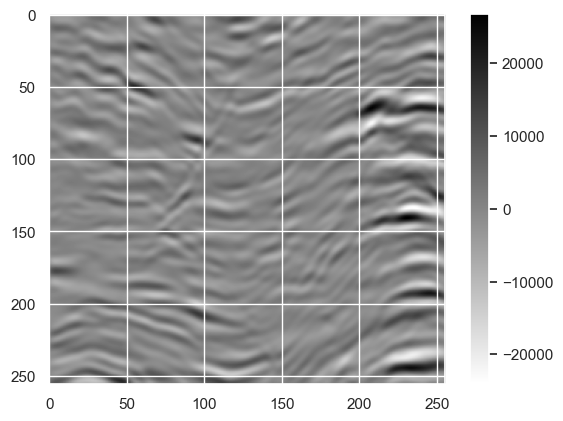

In [70]:
plt.imshow(inverted_impedance[150,:,:].T, aspect='auto', cmap='gray_r')
plt.colorbar()

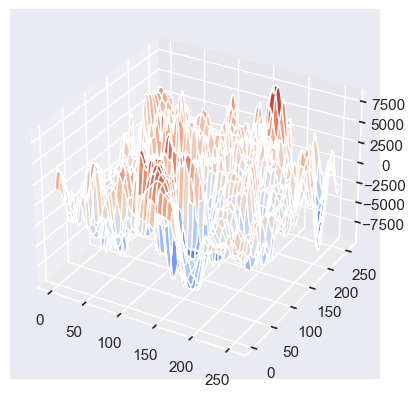

In [82]:
# Get the dimensions of the data
x_dim, y_dim, z_dim = data_amp.shape

# Create x, y, and z coordinate arrays
x, y, z = np.meshgrid(np.arange(x_dim), np.arange(y_dim), np.arange(z_dim), indexing='ij')

fig, ax = plt.subplots(subplot_kw={'projection':'3d'})
ax.plot_surface(x[:,:,128], y[:,:,128], data_amp[:,:,128], cmap='coolwarm')